# Scrape Earnings History from Social Security Statement

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

### Importing Social Security Earnings History

Create an account on on my Social Security (https://www.ssa.gov/myaccount/). The table lists the "Earnings Taxed for Social Secuirty" and another column for "Earnings Taxed for Medicare". The latter column is the total earnings. The former column applies a "tax cap" - taxes are not applied above a certain threshold, which goes up every year with inflation. 

Unfortunately, the Social Security statement doesn't give the entire earnings history. It aggregates earnings from 1981-1990, 1991-2000, and 2001-2005. To get the full earnings history, click on "Review your full earnings record now". Save that html page in the same directory as the web scraping program. In Google Chrome, you can right click on any element of the table and go to "inspect", which will show you the html code for the table. Each row in the table has a `tr` tag, and within a row, each column has a data cell tag, `td`, except the first row, which has a header cell tag, `th`. 

![html code for one row of earnings history](Soc_Sec_Inspect_Chrome.png)


We could scrape data cell-by-data cell, or row-by-row. Here is the code for scraping rows. (You must download your own statement for this to work).

In [2]:
file = 'Earnings Record - Social Security.html'
with open(file, encoding='cp437') as file:
    contents = file.read() 
soup = BeautifulSoup(contents, 'html.parser')

We will eliminate the first row, which is the header. Also, the most recent years are on the top, so we will reverse the order of the table. Finally, if you download the earnings history early enough in the following year, it may show up as a row of zeros because the information is not yet reported to Social Security. If that's the case, you can eliminate the last row as well.

In [3]:
all_rows = soup.find_all(name='tr')
all_rows = all_rows[1:]
all_rows = all_rows[::-1]

Next, we want to strip out only the text in a row. Here's what one row's text looks like:

In [5]:
all_rows = [row.text.split() for row in all_rows]

In [6]:
all_rows[:10]

[['1977', '$41', '$41'],
 ['1978', '$59', '$59'],
 ['1979', '$58', '$58'],
 ['1980', '$46', '$46'],
 ['1981', '$429', '$429'],
 ['1982', '$172', '$172'],
 ['1983', '$10,533', '$10,533'],
 ['1984', '$25,386', '$25,386'],
 ['1985', '$30,061', '$30,061'],
 ['1986', '$32,730', '$32,730']]

Now we have a list of lists, which we can transform into a DataFrame

In [7]:
df = pd.DataFrame(all_rows, columns = ['Date', 'SS_Wages', 'Medicare_Wages'])
df.head(10)

,Date,SS_Wages,Medicare_Wages
0,1977,$41,$41
1,1978,$59,$59
2,1979,$58,$58
3,1980,$46,$46
4,1981,$429,$429
5,1982,$172,$172
6,1983,"$10,533","$10,533"
7,1984,"$25,386","$25,386"
8,1985,"$30,061","$30,061"
9,1986,"$32,730","$32,730"


We can set the `Date` column as the index for the DataFrame. Notice also that the other two columns of Social Security Wages and Medicare Wages are strings with a dollar sign and commas separating the thousands. We can use regular expressions to get rid of the dollar signs and commas and convert the data from strings to integers.

In [8]:
df = df.set_index('Date')
df.index.astype('int64')

df = df.replace('[\$,]', '', regex=True).astype(np.int64)
df.head()

# An alternative way of doing it is
#df = df.apply(lambda x: x.str[1:].str.split(',').str.join('')).astype(np.int64)

,SS_Wages,Medicare_Wages
Date,,
1977,41,41
1978,59,59
1979,58,58
1980,46,46
1981,429,429


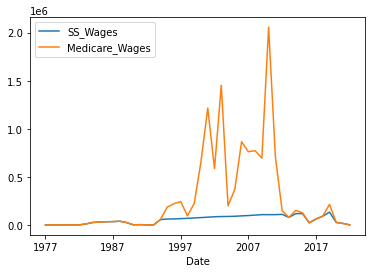

In [9]:
df.plot();

Social Security computes benefits based on your highest 35 years of earnings. So the next step is to try to forecast future earnings until the stated retirement date, in order to estimate expected Social Security benefits. This is not an easy task. For some people, seniority comes along with higher earnings. For others, earnings are hump-shaped reaching a peak in middle age and declining in later years. 